## Import required Librarys

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import tensorflow_hub as hub
import numpy as np
import cv2 

## Usefull functions

### function showing progres in learning of the model

In [2]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

### function to make preatty confusion_matrix

In [3]:

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 

  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

## Preparing data

In [4]:
train_path = 'C:/Users/48517/Desktop/ML/project_vol2/gesture/train'
test_path = 'C:/Users/48517/Desktop/ML/project_vol2/gesture/test'
valid_path = 'C:/Users/48517/Desktop/ML/project_vol2/gesture/validate'

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (64, 64)                              

#shuffle train dataset
train = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=True)
                                                                
validate = tf.keras.preprocessing.image_dataset_from_directory(valid_path,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE,
                                                                        shuffle=False)

test = tf.keras.preprocessing.image_dataset_from_directory(test_path,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE,
                                                                        shuffle=False)


Found 14424 files belonging to 24 classes.
Found 1026 files belonging to 24 classes.
Found 989 files belonging to 24 classes.


## Create checkpoint_callback to be able to continue training model

In [6]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [7]:
# Setup checkpoint path
checkpoint_path = "C:/Users/48517/Desktop/ML/project_vol2/checkpoints/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=True, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch")

## Create model using transfer learnining with EfficientNetB0

In [8]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),# keep for ResNet50V2, remove for EfficientNet  0.25                 
], name="data_augmentation")
# add random distortion to pixels salt and pepper

# Setup the input shape to our model
input_shape = (64, 64, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(input_shape=(64, 64, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(24, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

## Train for 100 epocks

In [9]:
history_100_epocks = model.fit(train,
                                        
                                          epochs=100,
                                          validation_data=validate,
                                          validation_steps=len(validate), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "ProjectEfficientNet"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/ProjectEfficientNet/20230118-201354
Epoch 1/100
451/451 [==============================] - 35s 69ms/step - loss: 1.1467 - accuracy: 0.7110 - val_loss: 1.4521 - val_accuracy: 0.5517
Epoch 2/100
451/451 [==============================] - 29s 65ms/step - loss: 0.5304 - accuracy: 0.8712 - val_loss: 1.3162 - val_accuracy: 0.6248
Epoch 3/100
451/451 [==============================] - 30s 66ms/step - loss: 0.3970 - accuracy: 0.9016 - val_loss: 1.2262 - val_accuracy: 0.6384
Epoch 4/100
451/451 [==============================] - 29s 65ms/step - loss: 0.3288 - accuracy: 0.9174 - val_loss: 1.1825 - val_accuracy: 0.6618
Epoch 5/100
451/451 [==============================] - 30s 65ms/step - loss: 0.2850 - accuracy: 0.9273 - val_loss: 1.1876 - val_accuracy: 0.6598
Epoch 6/100
451/451 [==============================] - 31s 69ms/step - loss: 0.2458 - accuracy: 0.9389 - val_loss: 1.1552 - val_accuracy: 0.6745
Epoch 7/100
451/451 [======================

451/451 [==============================] - 29s 63ms/step - loss: 0.0726 - accuracy: 0.9809 - val_loss: 1.3863 - val_accuracy: 0.7212
Epoch 57/100
451/451 [==============================] - 29s 63ms/step - loss: 0.0715 - accuracy: 0.9807 - val_loss: 1.3362 - val_accuracy: 0.7086
Epoch 58/100
451/451 [==============================] - 29s 64ms/step - loss: 0.0705 - accuracy: 0.9796 - val_loss: 1.3207 - val_accuracy: 0.7251
Epoch 59/100
451/451 [==============================] - 29s 64ms/step - loss: 0.0694 - accuracy: 0.9794 - val_loss: 1.4061 - val_accuracy: 0.7203
Epoch 60/100
451/451 [==============================] - 29s 64ms/step - loss: 0.0716 - accuracy: 0.9795 - val_loss: 1.3854 - val_accuracy: 0.6979
Epoch 61/100
451/451 [==============================] - 29s 64ms/step - loss: 0.0693 - accuracy: 0.9813 - val_loss: 1.3979 - val_accuracy: 0.7173
Epoch 62/100
451/451 [==============================] - 29s 64ms/step - loss: 0.0666 - accuracy: 0.9824 - val_loss: 1.3760 - val_accuracy

### Show the performance of the model

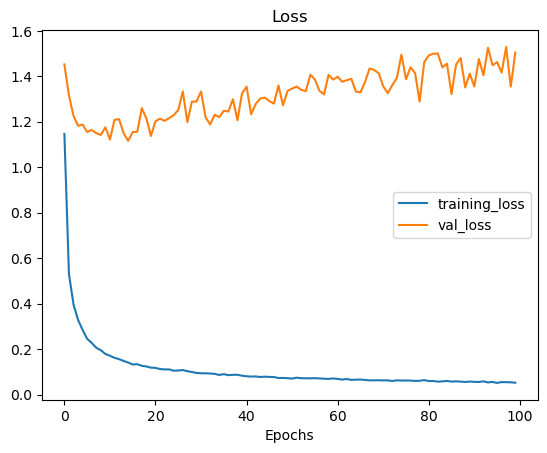

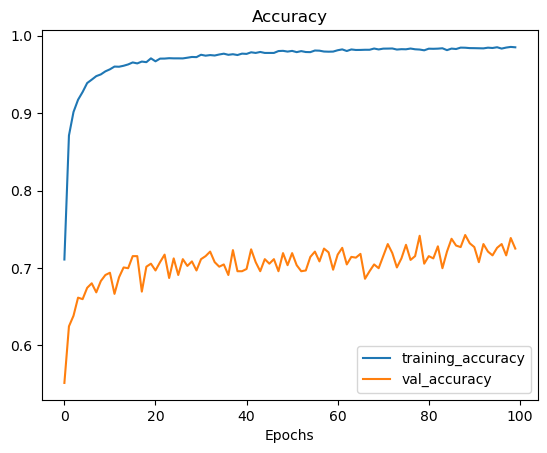

In [10]:
plot_loss_curves(history_100_epocks)

## Save the model and then try to improve it

In [11]:
model.save('model_EfficientNetB0.h5')

## Evaluate it on test dataset

In [12]:
# Make predictions with model
pred_probs = model.predict(test)

31/31 [==============================] - 3s 57ms/step


In [13]:
# Get the class names
class_names = validate.class_names
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

In [14]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [15]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [16]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.7360970677451971

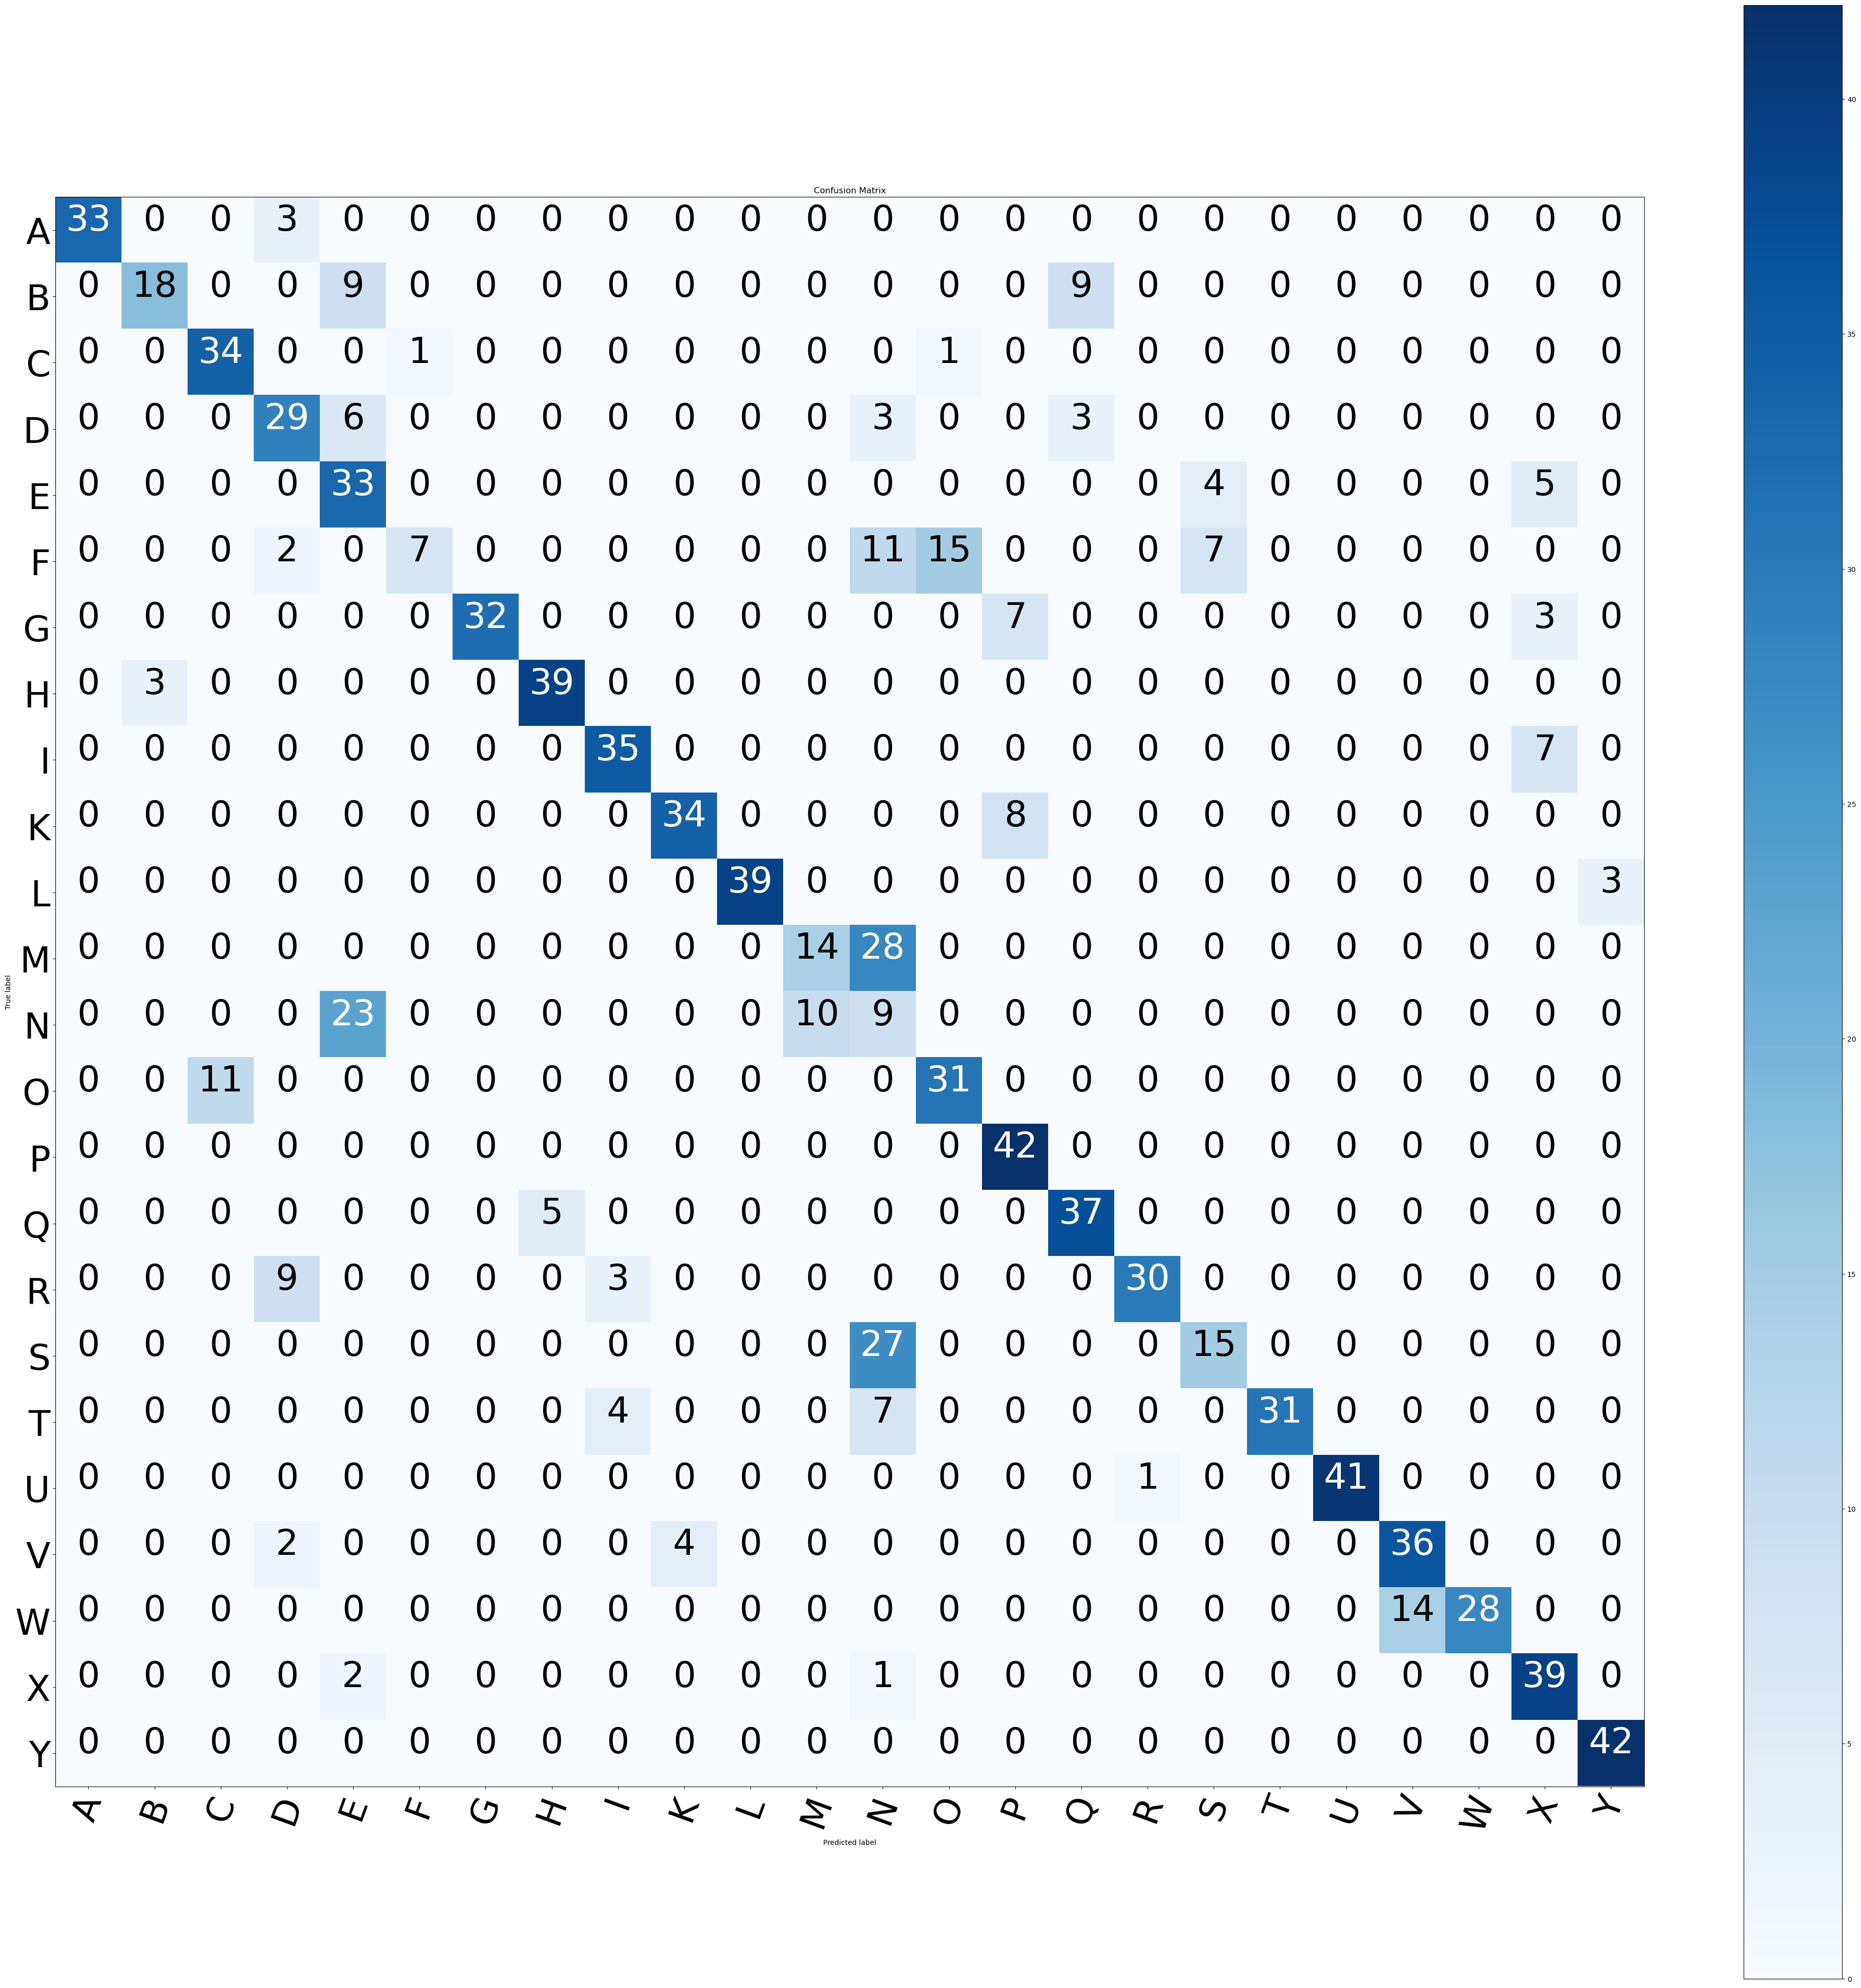

In [17]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=50,
                      norm=False,
                      savefig=True)

In [18]:

from sklearn.metrics import classification_report
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [19]:

# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'A': 0.9565217391304348,
 'B': 0.631578947368421,
 'C': 0.8395061728395062,
 'D': 0.6744186046511628,
 'E': 0.5739130434782609,
 'F': 0.27999999999999997,
 'G': 0.8648648648648648,
 'H': 0.9069767441860465,
 'I': 0.8333333333333334,
 'K': 0.8500000000000001,
 'L': 0.962962962962963,
 'M': 0.4242424242424242,
 'N': 0.14062500000000003,
 'O': 0.6966292134831461,
 'P': 0.8484848484848484,
 'Q': 0.8131868131868131,
 'R': 0.821917808219178,
 'S': 0.4411764705882353,
 'T': 0.8493150684931507,
 'U': 0.9879518072289156,
 'V': 0.782608695652174,
 'W': 0.8,
 'X': 0.8125000000000001,
 'Y': 0.9655172413793104}

In [20]:

# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
19,U,0.987952
23,Y,0.965517
10,L,0.962963
0,A,0.956522
7,H,0.906977
6,G,0.864865
9,K,0.850000
18,T,0.849315
14,P,0.848485
2,C,0.839506


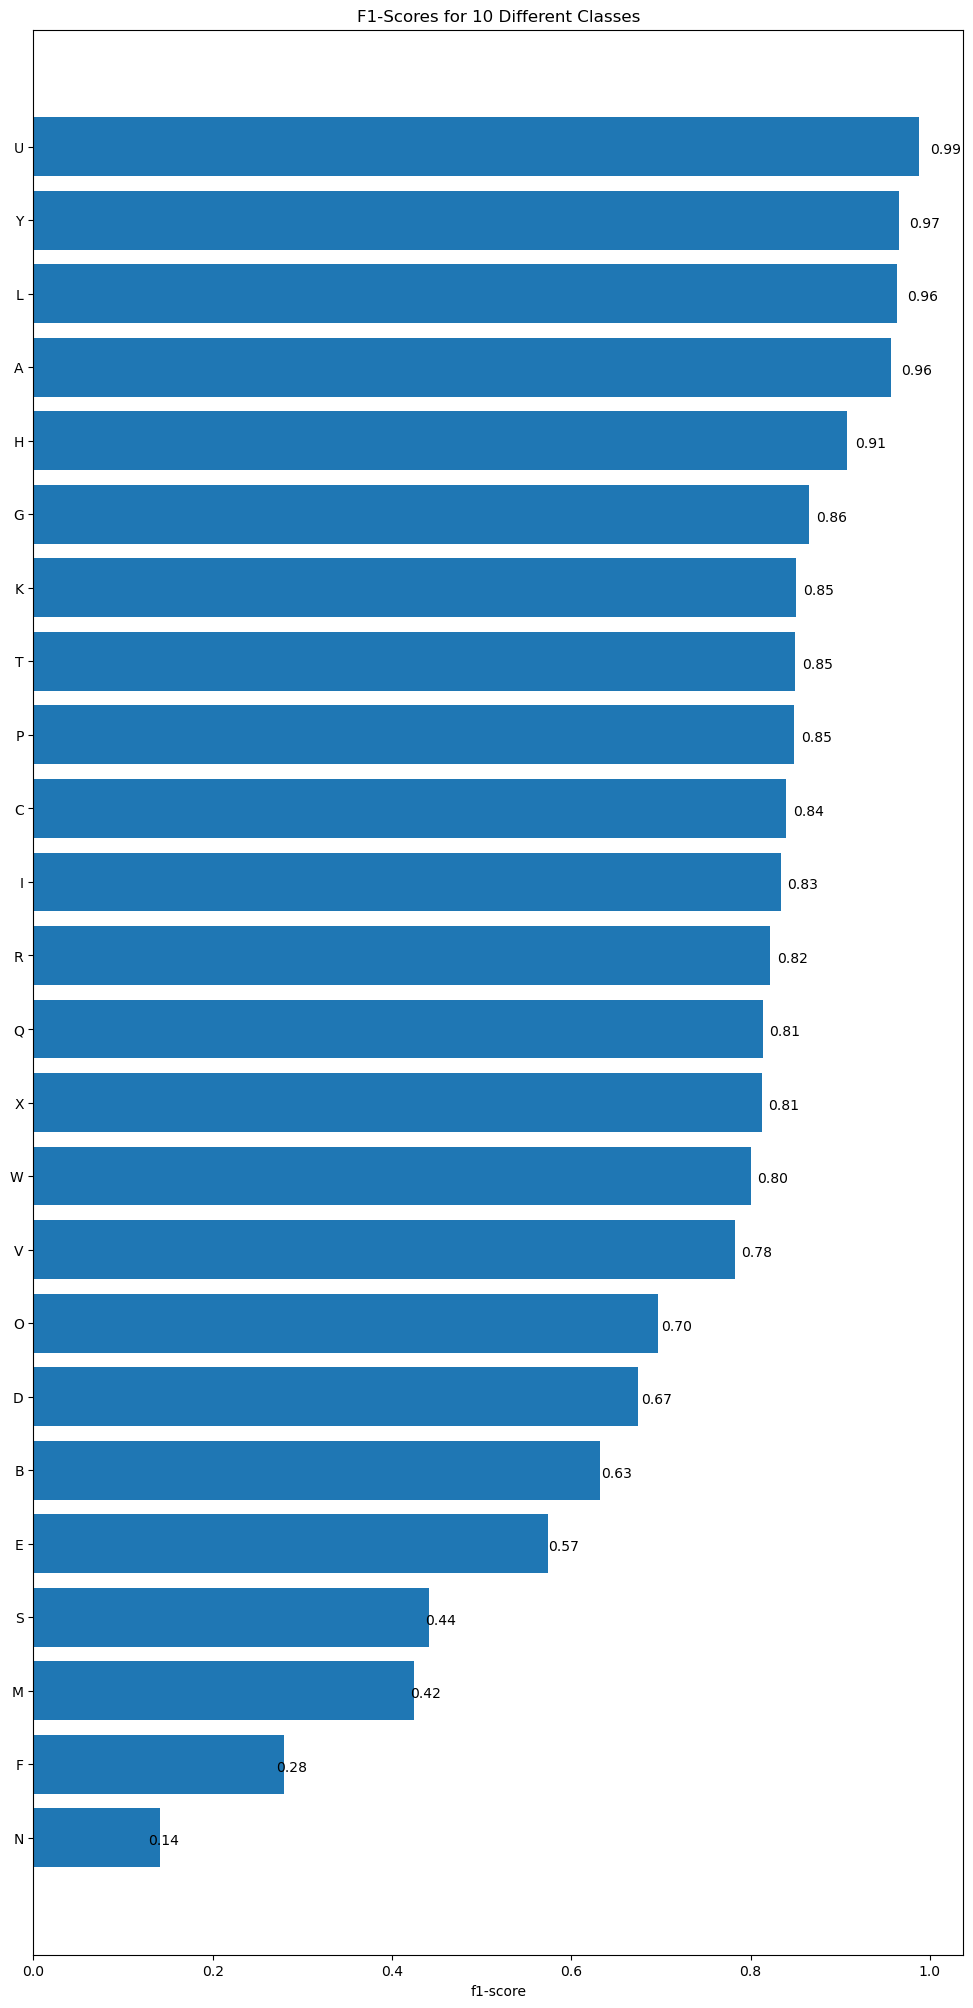

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Resnet

In [22]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),# keep for ResNet50V2, remove for EfficientNet  0.25 
  preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name="data_augmentation")
# add random distortion to pixels salt and pepper

# Setup the input shape to our model
input_shape = (64, 64, 3)

# Create a frozen base model
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(64,64,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(24, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [23]:
history_resnet = model.fit(train,
                                        
                                          epochs=100,
                                          validation_data=validate,
                                          validation_steps=len(validate), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "ProjecResNet"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/ProjecResNet/20230118-210423
Epoch 1/100
451/451 [==============================] - 60s 127ms/step - loss: 2.5976 - accuracy: 0.2896 - val_loss: 2.4308 - val_accuracy: 0.2037
Epoch 2/100
451/451 [==============================] - 58s 128ms/step - loss: 2.0474 - accuracy: 0.4610 - val_loss: 2.1928 - val_accuracy: 0.2953
Epoch 3/100
451/451 [==============================] - 60s 132ms/step - loss: 1.7967 - accuracy: 0.5347 - val_loss: 2.0469 - val_accuracy: 0.3421
Epoch 4/100
451/451 [==============================] - 59s 130ms/step - loss: 1.6207 - accuracy: 0.5805 - val_loss: 1.9648 - val_accuracy: 0.3577
Epoch 5/100
451/451 [==============================] - 58s 129ms/step - loss: 1.5048 - accuracy: 0.6112 - val_loss: 1.9081 - val_accuracy: 0.3733
Epoch 6/100
451/451 [==============================] - 58s 128ms/step - loss: 1.4064 - accuracy: 0.6308 - val_loss: 1.8489 - val_accuracy: 0.3928
Epoch 7/100
451/451 [=======================

451/451 [==============================] - 61s 135ms/step - loss: 0.6409 - accuracy: 0.8169 - val_loss: 1.5661 - val_accuracy: 0.4942
Epoch 57/100
451/451 [==============================] - 60s 132ms/step - loss: 0.6292 - accuracy: 0.8265 - val_loss: 1.5974 - val_accuracy: 0.4883
Epoch 58/100
451/451 [==============================] - 63s 140ms/step - loss: 0.6244 - accuracy: 0.8231 - val_loss: 1.5953 - val_accuracy: 0.5175
Epoch 59/100
451/451 [==============================] - 64s 142ms/step - loss: 0.6241 - accuracy: 0.8279 - val_loss: 1.6123 - val_accuracy: 0.4883
Epoch 60/100
451/451 [==============================] - 63s 140ms/step - loss: 0.6213 - accuracy: 0.8267 - val_loss: 1.5897 - val_accuracy: 0.5244
Epoch 61/100
451/451 [==============================] - 64s 141ms/step - loss: 0.6143 - accuracy: 0.8271 - val_loss: 1.6243 - val_accuracy: 0.5019
Epoch 62/100
451/451 [==============================] - 63s 141ms/step - loss: 0.6125 - accuracy: 0.8279 - val_loss: 1.6000 - val_a

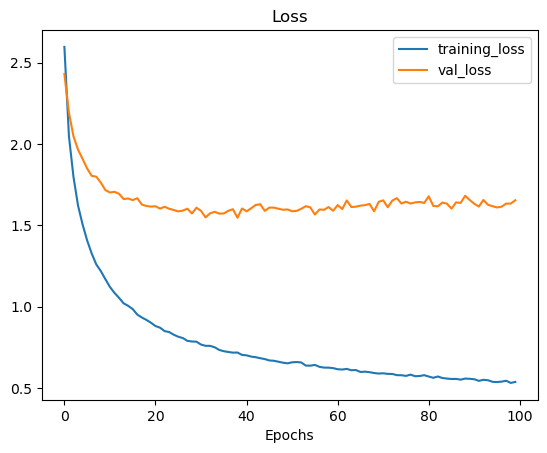

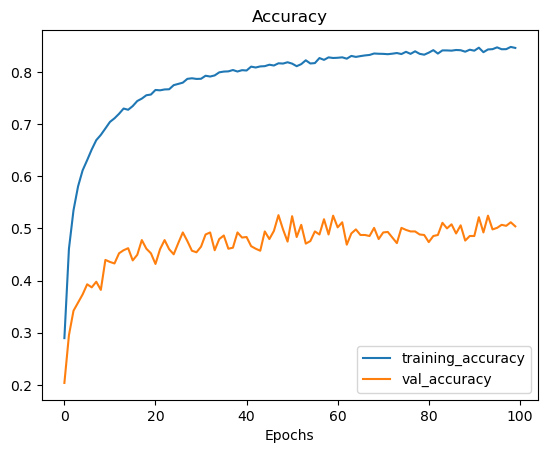

In [24]:
plot_loss_curves(history_resnet)

In [25]:
# Make predictions with model
pred_probs = model.predict(test)

31/31 [==============================] - 4s 115ms/step


In [26]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [27]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [28]:
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5652173913043478

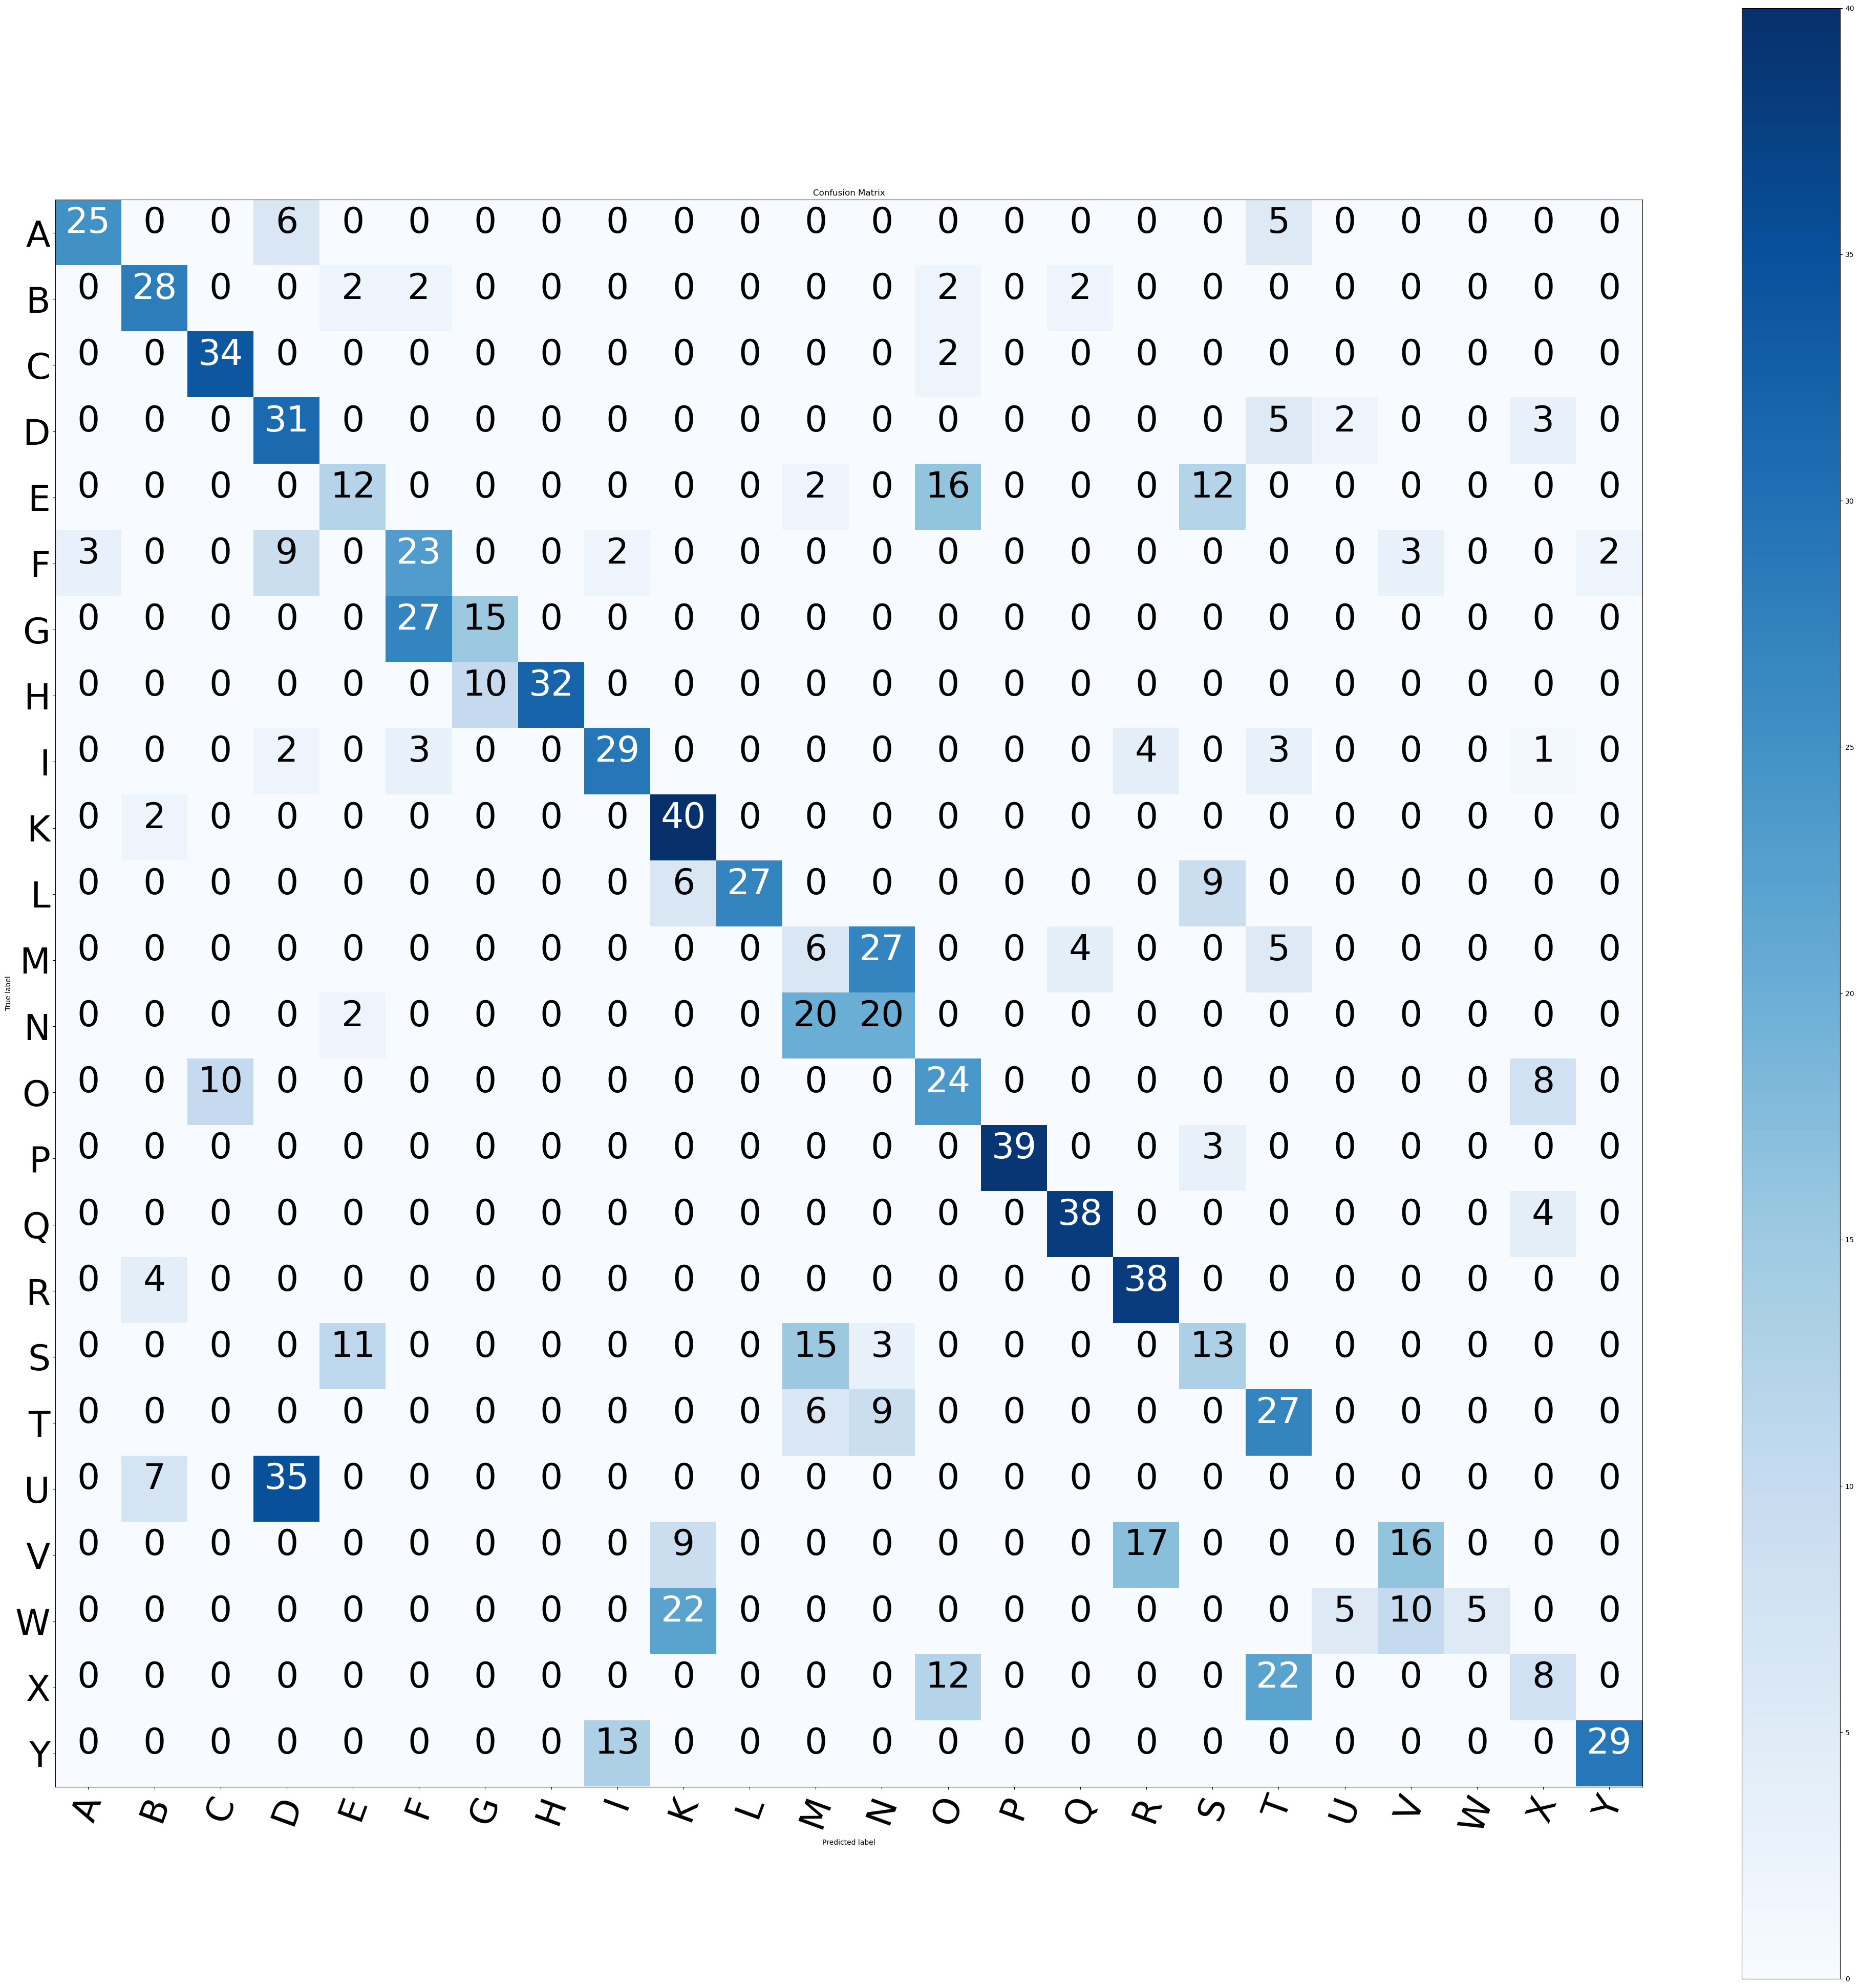

In [29]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=50,
                      norm=False,
                      savefig=False)

## MobileNetV2

In [30]:
# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomRotation(0.2),# keep for ResNet50V2, remove for EfficientNet  0.25 
  preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet
], name="data_augmentation")
# add random distortion to pixels salt and pepper

# Setup the input shape to our model
input_shape = (64, 64, 3)

# Create a frozen base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(64,64,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(24, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [31]:
history_MobileNetV2 = model.fit(train,
                                        
                                          epochs=100,
                                          validation_data=validate,
                                          validation_steps=len(validate), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "ProjecMobileNetV2t"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/ProjecMobileNetV2t/20230118-224615
Epoch 1/100
451/451 [==============================] - 21s 43ms/step - loss: 1.3388 - accuracy: 0.6269 - val_loss: 1.6311 - val_accuracy: 0.4756
Epoch 2/100
451/451 [==============================] - 19s 41ms/step - loss: 0.7427 - accuracy: 0.7949 - val_loss: 1.5666 - val_accuracy: 0.5049
Epoch 3/100
451/451 [==============================] - 20s 43ms/step - loss: 0.5984 - accuracy: 0.8333 - val_loss: 1.4560 - val_accuracy: 0.5370
Epoch 4/100
451/451 [==============================] - 19s 43ms/step - loss: 0.5254 - accuracy: 0.8487 - val_loss: 1.4644 - val_accuracy: 0.5575
Epoch 5/100
451/451 [==============================] - 19s 43ms/step - loss: 0.4836 - accuracy: 0.8620 - val_loss: 1.5967 - val_accuracy: 0.5156
Epoch 6/100
451/451 [==============================] - 19s 43ms/step - loss: 0.4514 - accuracy: 0.8666 - val_loss: 1.5608 - val_accuracy: 0.5224
Epoch 7/100
451/451 [=======================

451/451 [==============================] - 18s 41ms/step - loss: 0.2340 - accuracy: 0.9291 - val_loss: 1.8886 - val_accuracy: 0.5780
Epoch 57/100
451/451 [==============================] - 19s 42ms/step - loss: 0.2416 - accuracy: 0.9236 - val_loss: 1.8464 - val_accuracy: 0.5916
Epoch 58/100
451/451 [==============================] - 18s 41ms/step - loss: 0.2327 - accuracy: 0.9252 - val_loss: 2.0471 - val_accuracy: 0.5448
Epoch 59/100
451/451 [==============================] - 18s 40ms/step - loss: 0.2331 - accuracy: 0.9260 - val_loss: 1.9852 - val_accuracy: 0.5419
Epoch 60/100
451/451 [==============================] - 18s 40ms/step - loss: 0.2261 - accuracy: 0.9303 - val_loss: 1.9058 - val_accuracy: 0.5634
Epoch 61/100
451/451 [==============================] - 18s 41ms/step - loss: 0.2340 - accuracy: 0.9247 - val_loss: 2.0512 - val_accuracy: 0.5468
Epoch 62/100
451/451 [==============================] - 19s 42ms/step - loss: 0.2370 - accuracy: 0.9250 - val_loss: 1.9593 - val_accuracy

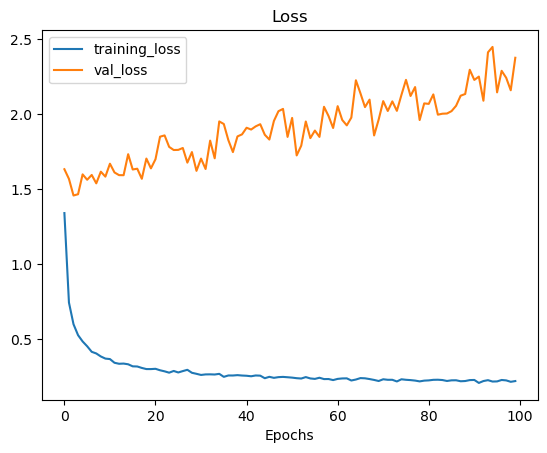

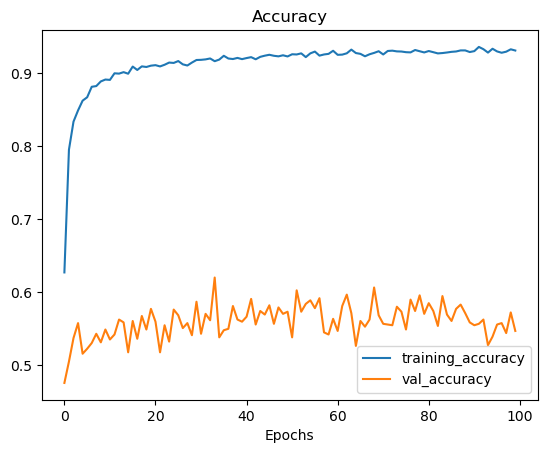

In [32]:
plot_loss_curves(history_MobileNetV2)

In [33]:
# Make predictions with model
pred_probs = model.predict(test)

31/31 [==============================] - 2s 36ms/step


In [34]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

In [35]:
# Note: This might take a minute or so due to unravelling 790 batches
y_labels = []
for images, labels in test.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [36]:
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5399393326592518

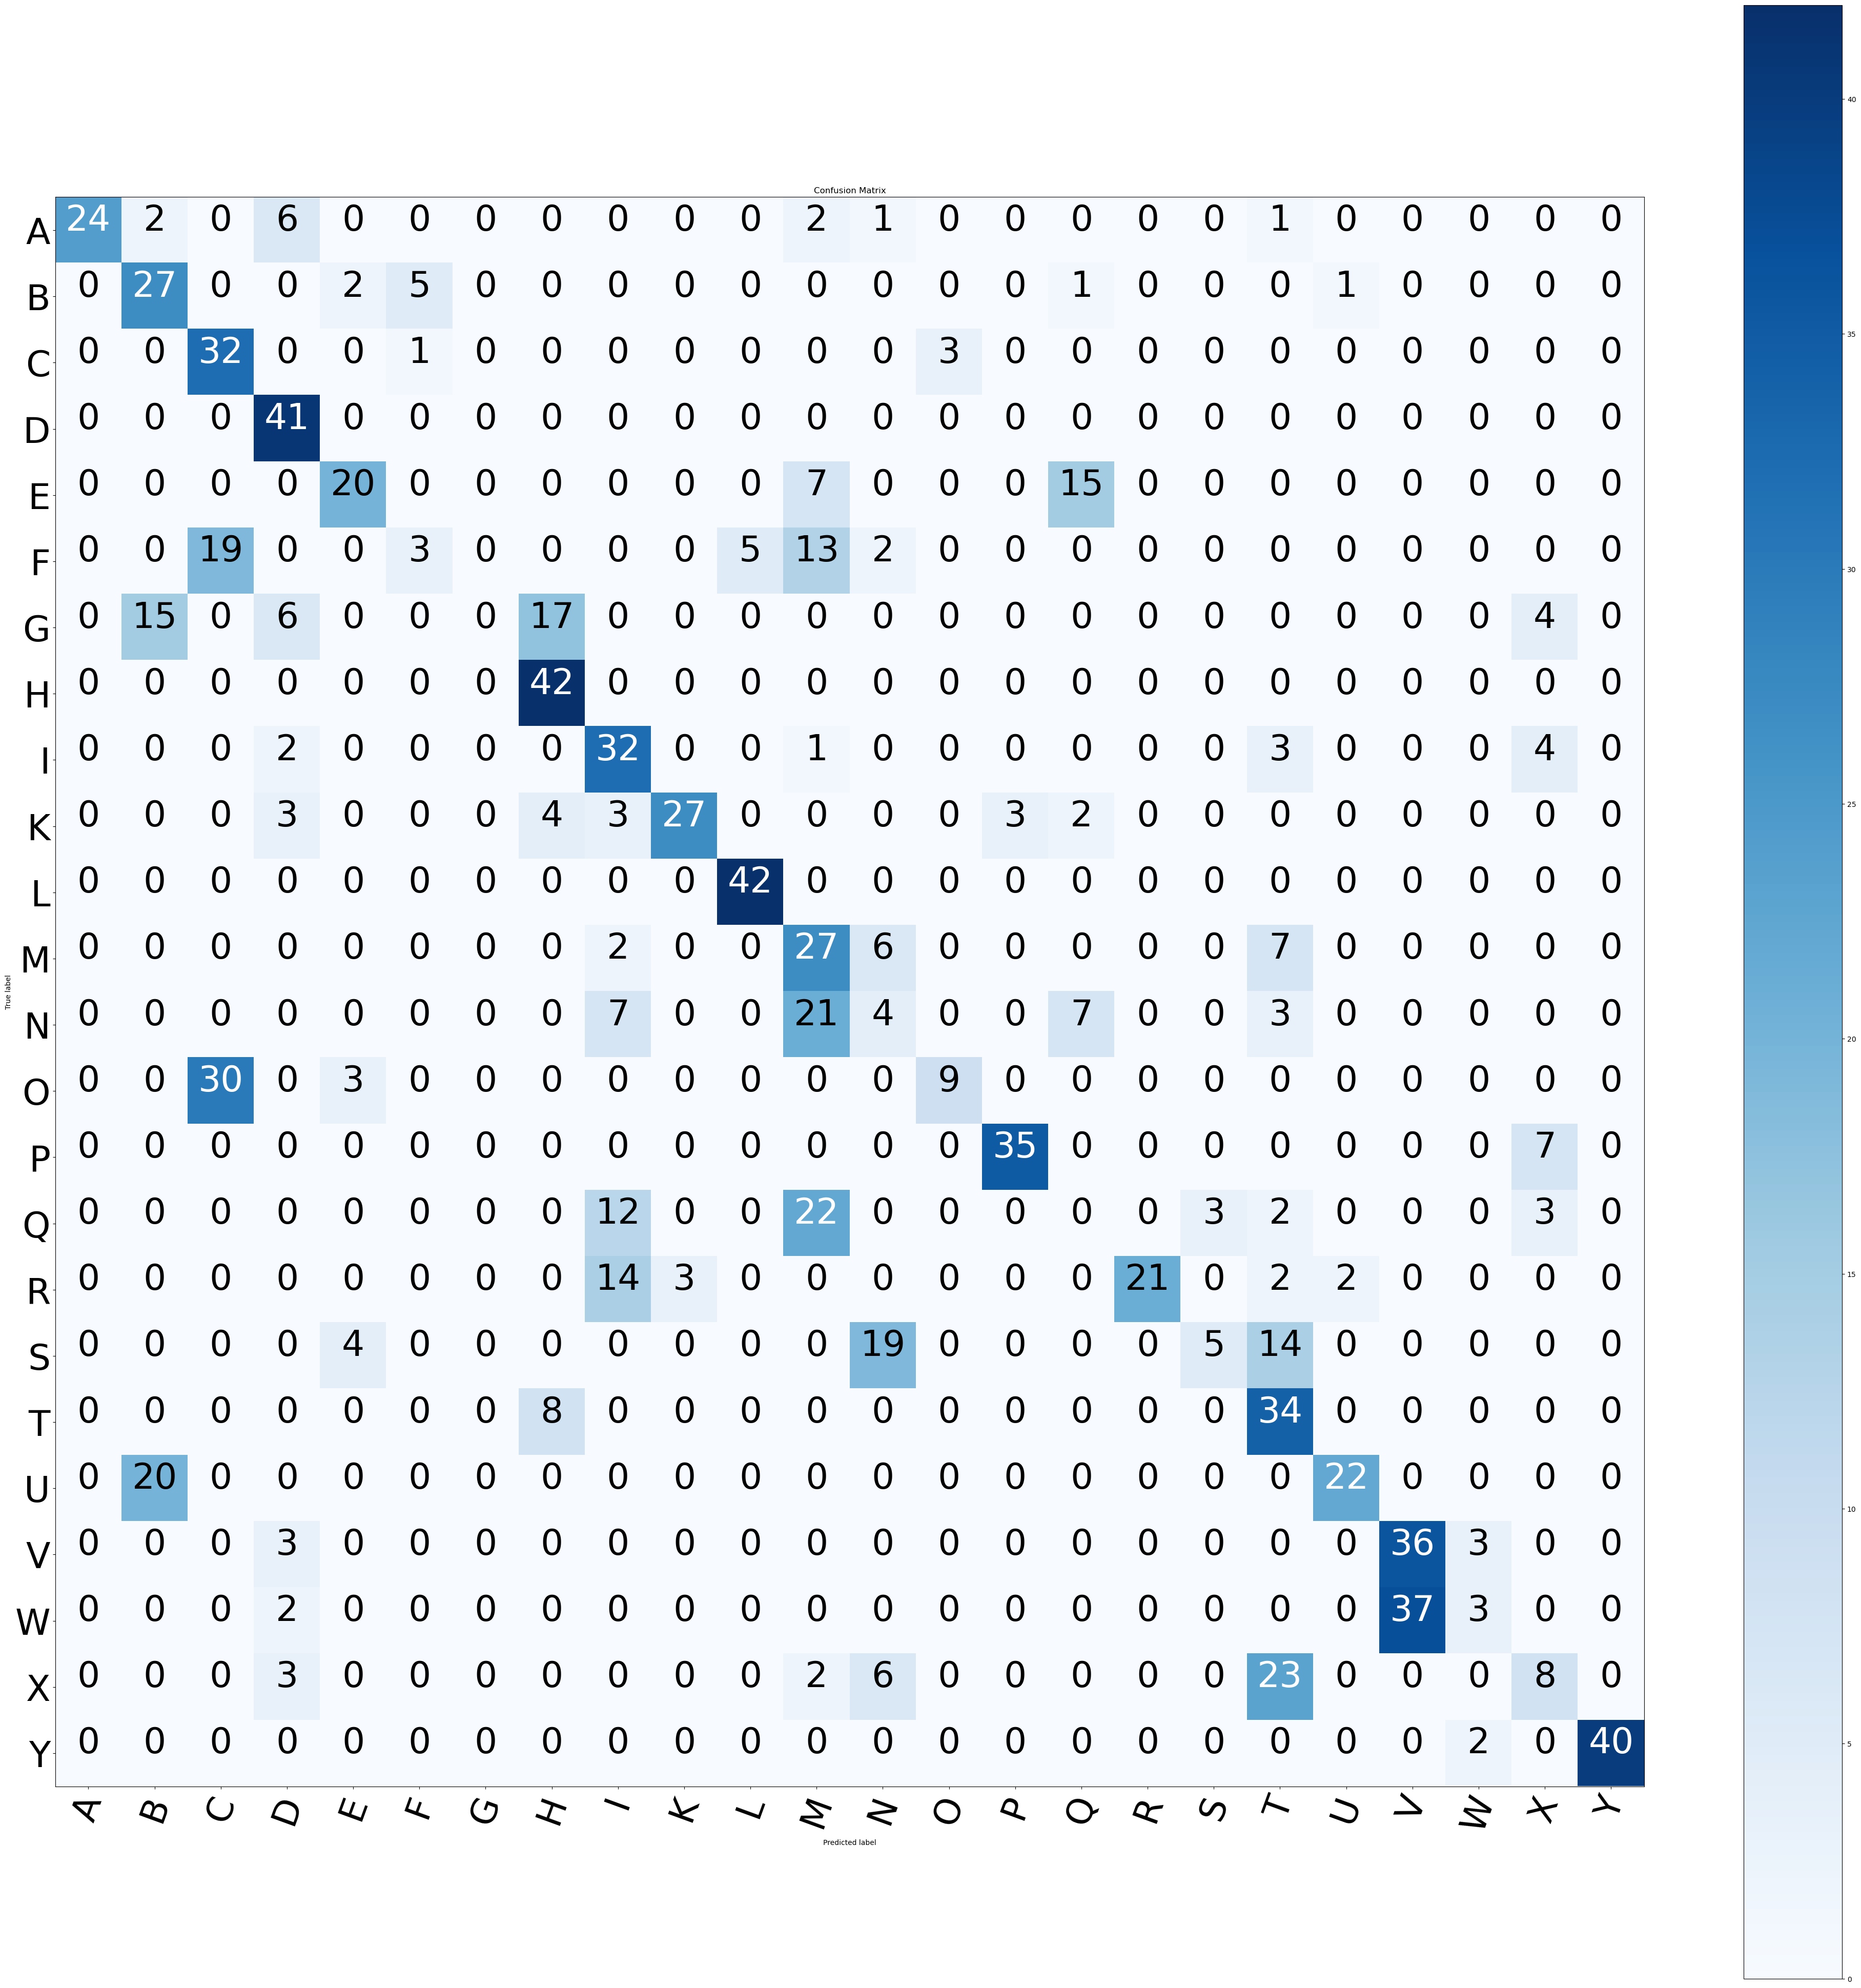

In [37]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(50, 50),
                      text_size=50,
                      norm=False,
                      savefig=False)

In [39]:
model.load_weights(checkpoint_path)

ValueError: Received incompatible tensor with shape (1, 1, 48, 1152) when attempting to restore variable with shape (1, 1, 320, 1280) and name layer_with_weights-0/layer_with_weights-102/kernel/.ATTRIBUTES/VARIABLE_VALUE.